In [128]:
%pylab inline
import os
import pandas as pd
import networkx as nx
import powerlaw
import seaborn as sns

from tqdm.notebook import tqdm

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [154]:
important_years = {
    1972 : 'Title IX',
    1993 : 'FMLA'
}

### Basic considerations dataset

Here I will compute some basic statistics of the dataset in order to understand some of its properties. In particular, I am be interested in some preliminary analyses to better understand what I can do with this dataset. Some of the questions are:

- do men and women researchers show homophily in their collaboration patterns?
- do man and women experience the friendship paradox in the same way?
- do men and women have the same amount of single author paper?
 - do they have the same pattern on the number of collaborators? Aka, same number of co-authors. In other words, do they engage in large or small collaborations in the same way?
 - same fraction of first author and last author papers?
- do they experience same dropout rate?
- how many first-author papers before a last author paper?



In [2]:
def make_network():
    
    G = nx.Graph()
    
    with open("../data/collab_network_bravo/AuthorNodes.csv", 'rt') as rr:
        for n, line in enumerate(rr):
            
            if n == 0:
                # it is the header
                continue
            node_id, gender, _, _ = line.strip().split(",")
            G.add_node(node_id, gender=gender, bipartite=0)
            
    with open("../data/collab_network_bravo/PublicationNodes.csv", 'rt') as rr:
        for n, line in enumerate(rr):
            
            if n == 0:
                # it is the header
                continue
            node_id, year = line.strip().split(",")
            G.add_node(node_id, year=year, bipartite=1)
            
    with open("../data/collab_network_bravo/Edges.csv", 'rt') as rr:
        for n, line in enumerate(rr):
            
            if n == 0:
                # it is the header
                continue
            author, paper, auth_position = line.strip().split(",")
            G.add_edge(author, paper, position=auth_position)
            
    return G

In [21]:
# load data
# separately 
authors = pd.read_csv("../data/collab_network_bravo/AuthorNodes.csv").rename(columns={'Author_Node_ID':'author_id', 
                                                                 'Gender_Label_Refined':'gender'}).astype(str)
authors = authors[['author_id', 'gender']]
publications = pd.read_csv("../data/collab_network_bravo/PublicationNodes.csv", 
                           converters={'Publication_Node_ID':str, 
                                       'Year':int}).rename(columns={'Publication_Node_ID':'publication_id', 
                                                                           'Year':'year'})
edges = pd.read_csv("../data/collab_network_bravo/Edges.csv",
                    converters={'Publication_Node_ID':str,
                                'Author_Node_ID':str,
                                'Year':int}).rename(columns={'Author_Node_ID':'author_id', 'Publication_Node_ID':'publication_id',
                     'position':'Author_Position'})

all_author_ids = set(authors.author_id.astype(str))
all_author_male = set(authors.query("gender == 'male'").author_id)
all_author_female = set(authors.query("gender == 'female'").author_id)
all_publications_ids = set(publications.publication_id.astype(str))

n_authors_gender = authors.gender.value_counts()

# load as a network
G = make_network()

print("Number of Authors: ", authors.shape[0])
print("Number of Publications: ", publications.shape[0])
print("Number of authorship relationships: ", edges.shape[0])
print()
print(f"Number of males: {n_authors_gender['male']} ({round(n_authors_gender['male']/n_authors_gender.sum()*100, 2)}%)")
print(f"Number of females: {n_authors_gender['female']} ({round(n_authors_gender['female']/n_authors_gender.sum()*100, 2)}%)")
print(f"Number of unknown gender: {n_authors_gender['unknown']} ({round(n_authors_gender['unknown']/n_authors_gender.sum()*100, 2)}%)")



Number of Authors:  22911
Number of Publications:  23875
Number of authorship relationships:  50527

Number of males: 16179 (70.62%)
Number of females: 2997 (13.08%)
Number of unknown gender: 3735 (16.3%)


Well.. there are more unknown than female authors.

In [12]:
# connected components
conn_components = list(nx.connected_components(G))
conn_componets_authors = [cc - all_publications_ids for cc in conn_components]
conn_components_publlications = [cc - all_author_ids for cc in conn_components]

# get fraction of nodes in biggest CC
nodes_biggest_cc = max(conn_components, key=len)
authors_biggest_cc = nodes_biggest_cc - all_publications_ids
publications_biggest_cc = nodes_biggest_cc - all_author_ids

print(f"Nodes in biggest CC: {len(nodes_biggest_cc)} ({round(len(nodes_biggest_cc) / G.number_of_nodes() * 100, 2)}%)")
print(f"Publications in biggest CC: {len(publications_biggest_cc)} ({round(len(publications_biggest_cc) / len(all_publications_ids) * 100, 2)}%)")
print(f"Authors in biggest CC: {len(authors_biggest_cc)} ({round(len(authors_biggest_cc) / len(all_author_ids) * 100, 2)}%)")
print()

males_biggest_cc = authors_biggest_cc - set(authors.query("gender != 'male'").author_id)
females_biggest_cc = authors_biggest_cc - set(authors.query("gender != 'female'").author_id)
print(f"Male authors in biggest CC: {len(males_biggest_cc)} ({round(len(males_biggest_cc) / len(authors_biggest_cc) * 100, 2)}%)")
print(f"Female authors in biggest CC: {len(females_biggest_cc)} ({round(len(females_biggest_cc) / len(authors_biggest_cc) * 100, 2)}%)")


Nodes in biggest CC: 30124 (64.39%)
Publications in biggest CC: 16604 (69.55%)
Authors in biggest CC: 13520 (59.01%)

Male authors in biggest CC: 9634 (71.26%)
Female authors in biggest CC: 1916 (14.17%)


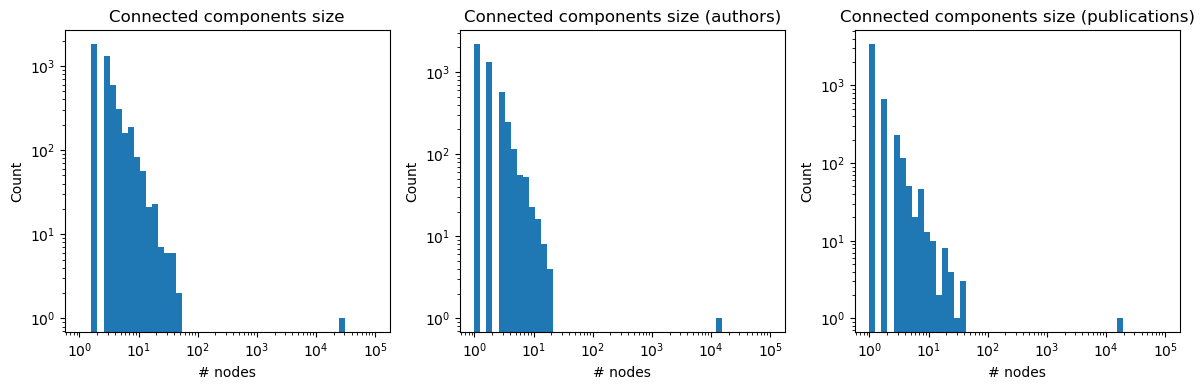

In [13]:
# show distributions connected components
plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
plt.hist([len(comp) for comp in conn_components], bins=np.logspace(0, 5, num=50));
plt.yscale('log')
plt.xscale('log')

plt.xlabel("# nodes")
plt.ylabel("Count")
plt.title("Connected components size")

plt.subplot(1, 3, 2)
plt.hist([len(comp) for comp in conn_componets_authors], bins=np.logspace(0, 5, num=50));
plt.yscale('log')
plt.xscale('log')

plt.xlabel("# nodes")
plt.ylabel("Count")
plt.title("Connected components size (authors)")


plt.subplot(1, 3, 3)
plt.hist([len(comp) for comp in conn_components_publlications], bins=np.logspace(0, 5, num=50));
plt.yscale('log')
plt.xscale('log')

plt.xlabel("# nodes")
plt.ylabel("Count")
plt.title("Connected components size (publications)")

plt.tight_layout()

There is one big connected components with ~10000 nodes, plus some other components composed of ~50 nodes max. Then, a lot of other small components (1 to 10 nodes).

The representation of male and female authors in the biggest CC is similar to the whole dataset. 

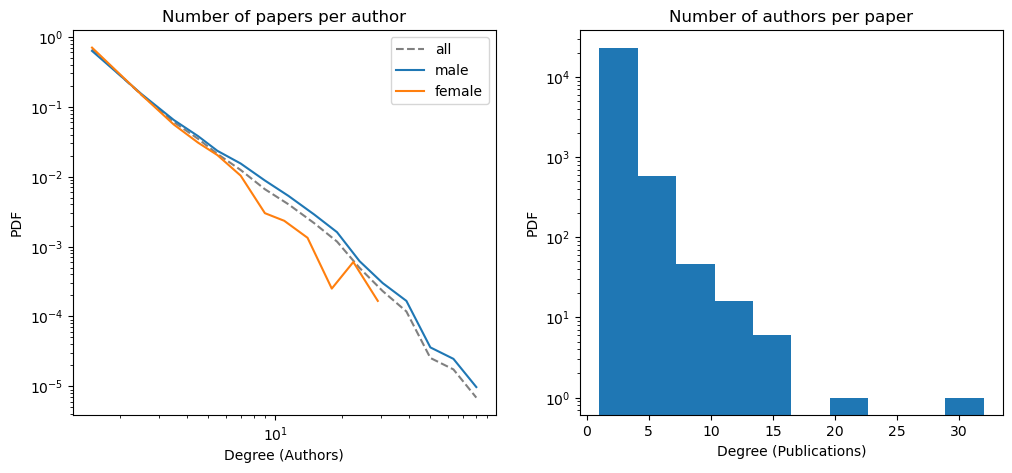

In [30]:
# distribution of papers per author and co-authors per paper
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
powerlaw.plot_pdf([deg for node, deg in G.degree(nbunch=all_author_ids)], label='all', 
                  color='grey', linestyle='dashed')
powerlaw.plot_pdf([deg for node, deg in G.degree(nbunch=all_author_male)], label='male')
powerlaw.plot_pdf([deg for node, deg in G.degree(nbunch=all_author_female)], label='female')

plt.xlabel("Degree (Authors)")
plt.ylabel("PDF")
plt.title("Number of papers per author")
plt.legend()


plt.subplot(1, 2, 2)
#powerlaw.plot_pdf([deg for node, deg in G.degree(nbunch=all_publications_ids)])
plt.hist([deg for node, deg in G.degree(nbunch=all_publications_ids)])

plt.xlabel("Degree (Publications)")
plt.ylabel("PDF")
plt.title("Number of authors per paper")
plt.yscale('log')


In [39]:
# more description of n authors per paper
print("Percentage of single-author papers: ", 
      round(np.mean([deg==1 for node, deg in G.degree(nbunch=all_publications_ids)])*100, 2), "%")
print("Percentage of two-author papers: ", 
      round(np.mean([deg==2 for node, deg in G.degree(nbunch=all_publications_ids)])*100, 2), "%")
print("Percentage of three-author papers: ", 
      round(np.mean([deg==3 for node, deg in G.degree(nbunch=all_publications_ids)])*100, 2), "%")
pd.Series([deg for node, deg in G.degree(nbunch=all_publications_ids)]).describe()

Percentage of single-author papers:  31.92 %
Percentage of two-author papers:  38.34 %
Percentage of three-author papers:  21.19 %


count    23875.000000
mean         2.116314
std          1.136418
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         32.000000
dtype: float64

Degree distributions of authors seem to be power-law like, however the max degree of women is way smaller than the one of men (30 Vs 80). Papers mainly written by small teams (60% with 2-3 authors) but also many single-author papers (32%).

Text(0.5, 1.0, 'Number of publications across time')

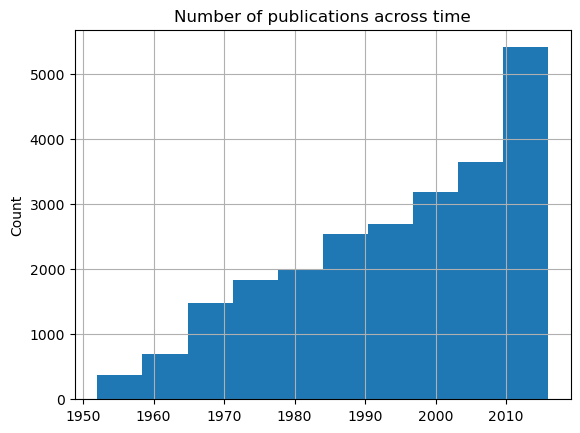

In [155]:
publications.year.hist()

plt.ylabel("Count")
plt.title("Number of publications across time")

#### Temporal considerations

Here I want to explore to what extent I have information about the career path of a researcher.

In [99]:
def get_firt_author_to_last_time(history):
    
    first_author_papers = []
    last_author_papers = []
    first_half_author_papers = []
    last_half_author_papers = []
    for hist in history:
        if hist[2] == 1:
            first_author_papers.append(hist[1])
        elif hist[2] == hist[3]:
            last_author_papers.append(hist[1])
                        
    if len(first_author_papers) * len(last_author_papers) == 0:
        return None
    else:
        return min(last_author_papers) - min(first_author_papers)

In [100]:
# create a list of tuple for each researcher
author_history = {}
publications = publications.set_index('publication_id')
for author_id in tqdm(all_author_ids, total=len(all_author_ids)):
    
    gender = authors.query(f"author_id == '{author_id}'").iloc[0].gender
    
    hist_ = []
    n_first_author = 0
    n_last_author = 0
    n_first_half_authors = 0
    n_last_half_authors = 0
    n_solo_papers = 0
    for paper, position in G[author_id].items():
        position = int(position['position'])
        n_authors_paper = G.degree(paper)
        hist_.append((paper, publications.loc[paper].year, position, n_authors_paper))
        
        # check only first/last author
        if n_authors_paper == 1:
            n_solo_papers += 1
        else:
            if position == 1:
                n_first_author += 1
            elif position == n_authors_paper:
                n_last_author += 1
            else:
                pass
        
        # if more than 4 authors, check if first or last half
        if n_authors_paper >= 4:
            if position <= n_authors_paper // 2:
                n_first_half_authors += 1
            else:
                n_last_half_authors += 1
        
    hist_ = sorted(hist_, key=lambda item: item[1])
    
    # time first first-author to last-author
    first_to_last_time = get_firt_author_to_last_time(hist_)
        
    author_history[author_id] = {
        'gender' : gender,
        'first_paper_year' : hist_[0][1],
        'last_paper_year' : hist_[-1][1],
        'years_of_activity' : hist_[-1][1] - hist_[0][1],
        'first_to_last_time' : first_to_last_time,
        'n_first_author' : n_first_author,
        'n_last_author' : n_last_author,
        'n_first_half_authors' : n_first_half_authors,
        'n_last_half_authors' : n_last_half_authors,
        'n_solo_papers' : n_solo_papers,
        'history' : hist_
    }
    
        
author_history = pd.DataFrame.from_dict(author_history, orient='index')
author_history.loc[:, 'n_papers'] = author_history.history.apply(len)
publications = publications.reset_index()

  0%|          | 0/22911 [00:00<?, ?it/s]

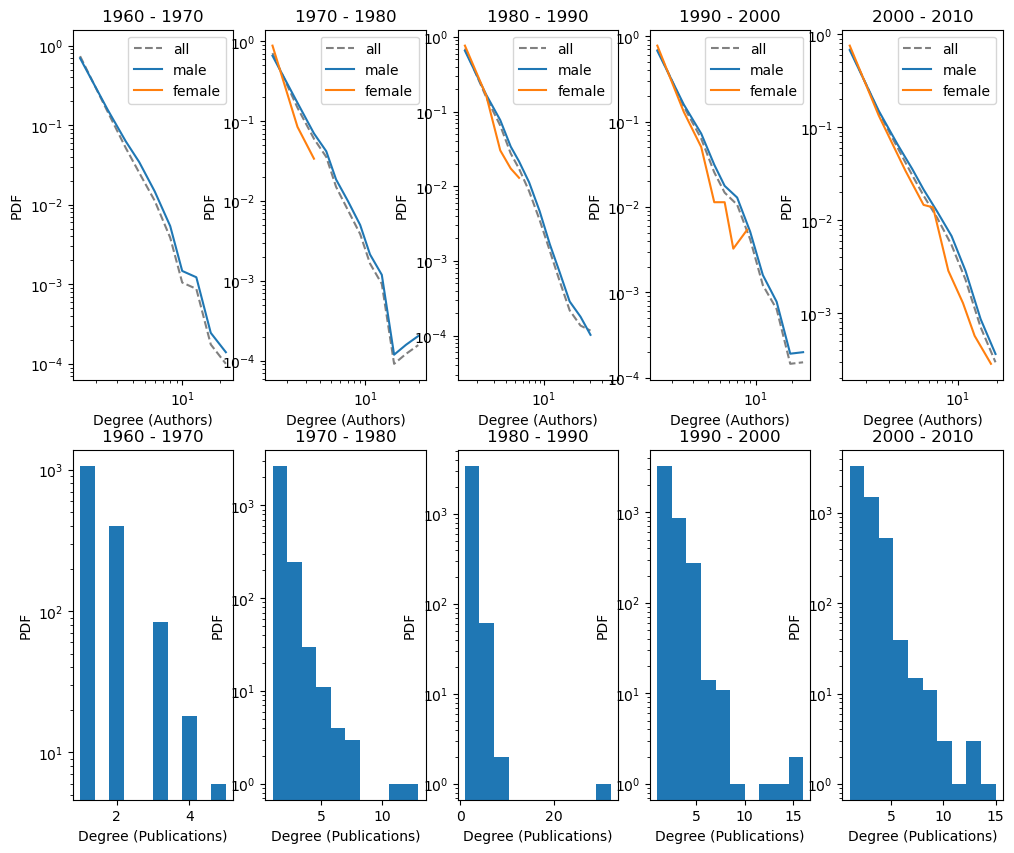

In [209]:
# show distribution of papers per author and co-authors per paper across time

time_bins = np.arange(1960, 2020, 10)
n_cols = time_bins.shape[0] - 1

plt.figure(figsize=(12,10))

for n, (year_lb, year_ub) in enumerate(zip(time_bins[:-1], time_bins[1:]), 1):
    
    publication_set = set(publications[(publications.year >= year_lb)&(publications.year < year_ub)].publication_id)
    author_set = set(edges[edges.publication_id.isin(publication_set)].author_id)
    G_slice = G.subgraph(publication_set.union(author_set))
    all_author_ids_ = set(G_slice.nodes()) - all_publications_ids
    all_author_male_ = all_author_ids_ - set(authors.query("gender != 'male'").author_id)
    all_author_female_ = all_author_ids_ - set(authors.query("gender != 'female'").author_id)

    plt.subplot(2, n_cols, n)
    powerlaw.plot_pdf([deg for node, deg in G_slice.degree(nbunch=all_author_ids_)], label='all', 
                      color='grey', linestyle='dashed')
    powerlaw.plot_pdf([deg for node, deg in G_slice.degree(nbunch=all_author_male_)], label='male')
    powerlaw.plot_pdf([deg for node, deg in G_slice.degree(nbunch=all_author_female_)], label='female')

    plt.xlabel("Degree (Authors)")
    plt.ylabel("PDF")
    #plt.title("Number of papers per author")
    plt.title(f"{year_lb} - {year_ub}")
    plt.legend()


    plt.subplot(2, n_cols, n + n_cols)
    #powerlaw.plot_pdf([deg for node, deg in G.degree(nbunch=all_publications_ids)])
    plt.hist([deg for node, deg in G.degree(nbunch=publication_set)])

    plt.xlabel("Degree (Publications)")
    plt.ylabel("PDF")
    #plt.title("Number of authors per paper")
    plt.title(f"{year_lb} - {year_ub}")
    plt.yscale('log')


In [176]:
publication_set

,publication_id,year
6463,5006548,1954
6464,5006549,1954
6465,5006550,1954
6466,5006551,1954
6467,5006552,1954
...,...,...
20545,5021085,1959
20546,5021086,1959
20547,5021087,1959
20548,5021088,1959


In [101]:
author_history.iloc[39].history

[('5004289', 2010, 1, 3), ('5001055', 2015, 3, 4)]

In [76]:
author_history.years_of_activity.describe()

count    22911.000000
mean         3.399110
std          7.263334
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max         59.000000
Name: years_of_activity, dtype: float64

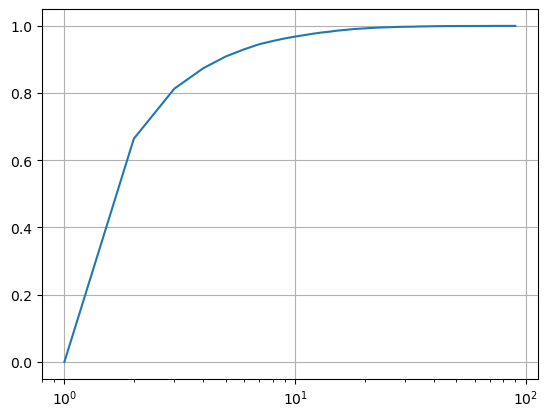

In [102]:
powerlaw.plot_cdf(author_history.n_papers)
plt.yscale('linear')
#plt.xscale('linear')
plt.grid()

In [103]:
author_history.n_first_author.describe()

count    22911.000000
mean         0.709485
std          1.500245
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         58.000000
Name: n_first_author, dtype: float64

In [104]:
author_history.n_last_author.describe()

count    22911.000000
mean         0.709485
std          1.642122
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         52.000000
Name: n_last_author, dtype: float64

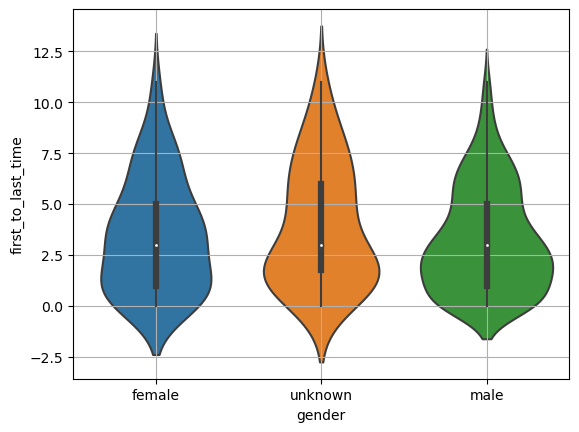

In [153]:
sns.violinplot(data=author_history[author_history.first_paper_year >= 2005]\
               .dropna(subset=['first_to_last_time']).query("first_to_last_time >= 0"), 
               y='first_to_last_time', x='gender')

plt.grid()

In [142]:
author_history.dropna(subset=['first_to_last_time']).query("first_to_last_time >= 0")\
                .groupby('gender').first_to_last_time.describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
female,240.0,6.900000,5.530289,0.0,3.0,5.0,10.0,31.0
male,1911.0,7.255364,7.008722,0.0,2.0,5.0,10.0,43.0
unknown,151.0,6.741722,6.712638,0.0,2.0,6.0,9.0,46.0


In [113]:
author_history.loc['1040654'].history

[('5021220', 1990, 3, 3),
 ('5022554', 1995, 1, 2),
 ('5022684', 1998, 1, 2),
 ('5021272', 1999, 1, 2)]